# import packages for velocyto

# import packages for single-cell-tools

In [300]:
import sys
sys.path.insert(1, '/dataVolume/storage/python_packages/single-cell-tools')
from sc_pseudotime import *

In [302]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


# files for single-cell-tools

In [303]:
cellset_file = "/dataVolume/storage/python_packages/single-cell-tools/resources/input/FACS_0407_2017_SHL_input_files/cell_sets_0407_SHL_20180523.csv"
settings_file = "/dataVolume/storage/python_packages/single-cell-tools/resources/input/FACS_0407_2017_SHL_input_files/plot_setting_0407_SHL_20180212.csv"

sett = settings(settings_file, cellset_file)
expression_file = "/dataVolume/storage/python_packages/single-cell-tools/resources/input/FACS_0407_2017_SHL_input_files/sunhye_census_matrix_20170407-comma_delimited.csv"
expression_table, annotation = read_expression(expression_file, sett, min_expression = 0.1, min_cells = 5)


Read expression table with shape: (312, 198002)
Removed genes that are not expressed > 0.1  in at least 5 cells
Expression table has now shape: (312, 91278)
Removed cells from set: low_aligned_cells ['X86', 'X54', 'X59', 'X48', 'X277', 'X61', 'X76', 'X157']
Removed cells from set: branch_b ['X123', 'X104', 'X217', 'X181', 'X288', 'X108', 'X154', 'X213', 'X132', 'X224', 'X140', 'X215', 'X228', 'X310', 'X297', 'X299', 'X17', 'X176', 'X258', 'X271', 'X274', 'X273', 'X284', 'X266', 'X282', 'X122', 'X120', 'X125', 'X110', 'X169', 'X45', 'X156', 'X166', 'X298', 'X129', 'X133', 'X93', 'X230']
Removed cells from set: branch_c ['X12', 'X78', 'X241', 'X257', 'X286', 'X19', 'X62', 'X221', 'X302', 'X303', 'X131', 'X146', 'X206', 'X96', 'X87', 'X88', 'X13', 'X84', 'X21', 'X261', 'X201', 'X116', 'X198', 'X148', 'X58', 'X182']
Removed cells from set: outliers ['X104', 'X217', 'X159', 'X98', 'X72', 'X122', 'X123', 'X257', 'X288', 'X40', 'X70']
Log transformed data


# reformat cell names 

In [304]:
annotation.index = annotation.index.str.replace('X', 'shl20170407_S')

# load loom file

In [305]:
loom_file = "/dataVolume/storage/single_cell_projects/sc_RB_devel/20170407-SHL-FACS-Hs_proj/output/velocyto/MyTissue.loom"

In [299]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import loompy
import velocyto as vcy
import scanpy as scn
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42



2020-01-14 14:17:56,683 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# functions for velocyto

In [301]:
# plotting utility functions
def despline():
    ax1 = plt.gca()
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    
def minimal_xticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    xlims = np.linspace(start, end_, 5)
    xlims_tx = [""]*len(xlims)
    xlims_tx[0], xlims_tx[-1] = f"{xlims[0]:.0f}", f"{xlims[-1]:.02f}"
    plt.xticks(xlims, xlims_tx)

def minimal_yticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    ylims = np.linspace(start, end_, 5)
    ylims_tx = [""]*len(ylims)
    ylims_tx[0], ylims_tx[-1] = f"{ylims[0]:.0f}", f"{ylims[-1]:.02f}"
    plt.yticks(ylims, ylims_tx)

# Load data

In [306]:
# Create an analysis object
vlm = vcy.VelocytoLoom(loom_file)

In [307]:
annotation[annotation.index.isin(vlm.ca['CellID'])]

,color,superimpose,superimpose-for-spearman,size,name,outline-color,day,shape,treatment,cluster
shl20170407_S1,gray,False,False,10,,gray,4.0,circle,shCtrl,shCtrl
shl20170407_S2,gray,False,False,10,,gray,4.0,circle,shCtrl,shCtrl
shl20170407_S3,gray,False,False,10,,gray,4.0,circle,shCtrl,shCtrl
shl20170407_S4,gray,False,False,10,,gray,4.0,circle,shCtrl,shCtrl
shl20170407_S5,gray,False,False,10,,gray,4.0,circle,shCtrl,shCtrl
...,...,...,...,...,...,...,...,...,...,...
shl20170407_S307,red,False,False,10,,red,12.0,circle,sh737,shRB1
shl20170407_S308,red,False,False,10,,red,12.0,circle,sh737,shRB1
shl20170407_S309,red,False,False,10,,red,12.0,circle,sh737,shRB1
shl20170407_S311,red,False,False,10,,red,12.0,circle,sh737,shRB1


In [308]:
annotation_index = np.isin(vlm.ca['CellID'], annotation.index)
annotation
vlm.filter_cells(annotation_index)
# annotation.index.to_numpy
# vlm.ca['CellID'].where(annotation.index)

In [309]:
colors_dict = dict(zip(annotation.color, annotation.color))


In [310]:
vlm.ca['CellID'].size
color_dict = {
    'default_cluster': [0.65,0.1,0.4]
}

vlm.ca['ClusterName'] = np.repeat(np.array(['default_cluster']), [vlm.ca['CellID'].size])
vlm.ca['ClusterName']
vlm.set_clusters(vlm.ca["ClusterName"], color_dict)


# Velocity Analysis

# filter cells by qc

In [311]:
vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.4))

In [312]:
# vlm.ts = np.column_stack([vlm.ca["TSNE1"], vlm.ca["TSNE2"]])

In [313]:
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
vlm.filter_genes(by_detection_levels=True)

2020-01-14 14:19:03,423 - DEBUG - Filtering by detection level


2020-01-14 14:19:03,459 - DEBUG - svr_gamma set to 0.03775484520513466
2020-01-14 14:19:04,116 - DEBUG - Filtering by cv vs mean


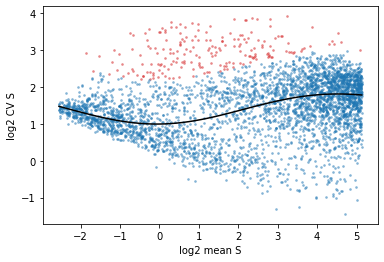

In [314]:
vlm.score_cv_vs_mean(200, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

In [315]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0, min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)

2020-01-14 14:19:04,231 - INFO - Cluster: default_cluster (234 cells)
2020-01-14 14:19:04,231 - DEBUG - Filtering by cluster expression
2020-01-14 14:19:04,232 - DEBUG - Filtering by detection level


In [316]:
# best with sample and expression scaling
vlm._normalize_S(relative_size=vlm.initial_cell_size,
                 target_size=np.mean(vlm.initial_cell_size))
vlm._normalize_U(relative_size=vlm.initial_Ucell_size,
                 target_size=np.mean(vlm.initial_Ucell_size))

73

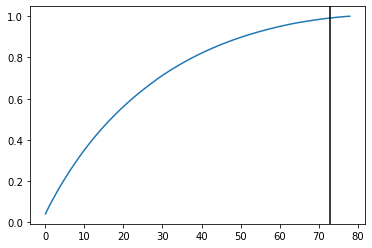

In [317]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
n_comps

In [319]:
k = 25
vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

2020-01-14 14:20:17,086 - DEBUG - First search the 200 nearest neighbours for 234
2020-01-14 14:20:17,191 - DEBUG - Using the initialization network to find a 25-NN graph with maximum connectivity of 100
2020-01-14 14:20:17,192 - DEBUG - Returning sparse matrix


In [320]:
vlm.fit_gammas(limit_gamma=False, fit_offset=False)

In [321]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

# run tSNE

In [322]:
from sklearn.manifold import TSNE
bh_tsne = TSNE()
vlm.ts = bh_tsne.fit_transform(vlm.pcs[:, :25])

In [323]:
vlm.pcn = getattr(vlm, "pcs")[:,0:2]

2020-01-14 14:23:04,324 - DEBUG - Assigning font /b'F1' = '/opt/miniconda3/envs/ARMOR/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2020-01-14 14:23:04,349 - DEBUG - Embedding font /opt/miniconda3/envs/ARMOR/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2020-01-14 14:23:04,349 - DEBUG - Writing TrueType font.


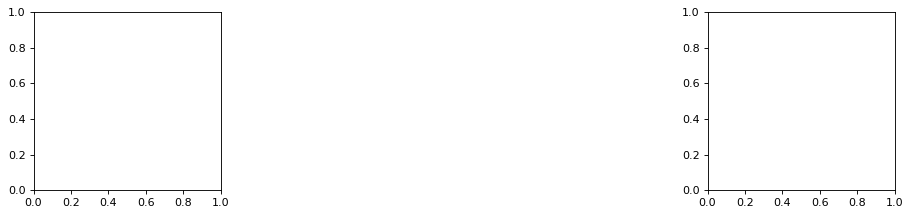

In [324]:
plt.figure(None, (17,2.8), dpi=80)
gs = plt.GridSpec(1,6)
for i, gn in enumerate(["ARR3","CRX"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    despline()
    
    vlm.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)

    vlm.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()
plt.savefig("Fig3_selection.pdf")

2020-01-14 14:23:05,575 - DEBUG - Assigning font /b'F1' = '/opt/miniconda3/envs/ARMOR/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2020-01-14 14:23:05,599 - DEBUG - Embedding font /opt/miniconda3/envs/ARMOR/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2020-01-14 14:23:05,600 - DEBUG - Writing TrueType font.


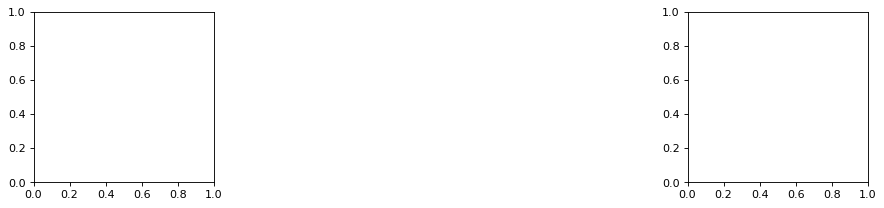

In [325]:
plt.figure(None, (16.5,15), dpi=80)
gs = plt.GridSpec(6,6)
for i, gn in enumerate(["VSX2", "OPN1SW"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    despline()
    
    vlm.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)

    vlm.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()
plt.savefig("Suppl_phase_selection.pdf")

In [326]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="pcn", transform="sqrt", psc=1,
                             n_neighbors=20, knn_random=True, sampled_fraction=0.5)

2020-01-14 14:23:09,051 - DEBUG - Calculate KNN in the embedding space
2020-01-14 14:23:09,172 - DEBUG - Correlation Calculation 'knn_random'
2020-01-14 14:23:09,173 - DEBUG - Correlation Calculation for negative control
2020-01-14 14:23:09,174 - DEBUG - Done Correlation Calculation


/opt/miniconda3/envs/ARMOR/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [328]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
vlm.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=30)

2020-01-14 14:23:20,278 - DEBUG - Calculate transition probability
2020-01-14 14:23:20,279 - DEBUG - Calculate transition probability for negative control


2020-01-14 14:33:24,845 - DEBUG - Assigning font /b'F1' = '/opt/miniconda3/envs/ARMOR/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2020-01-14 14:33:24,863 - DEBUG - Embedding font /opt/miniconda3/envs/ARMOR/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2020-01-14 14:33:24,863 - DEBUG - Writing TrueType font.


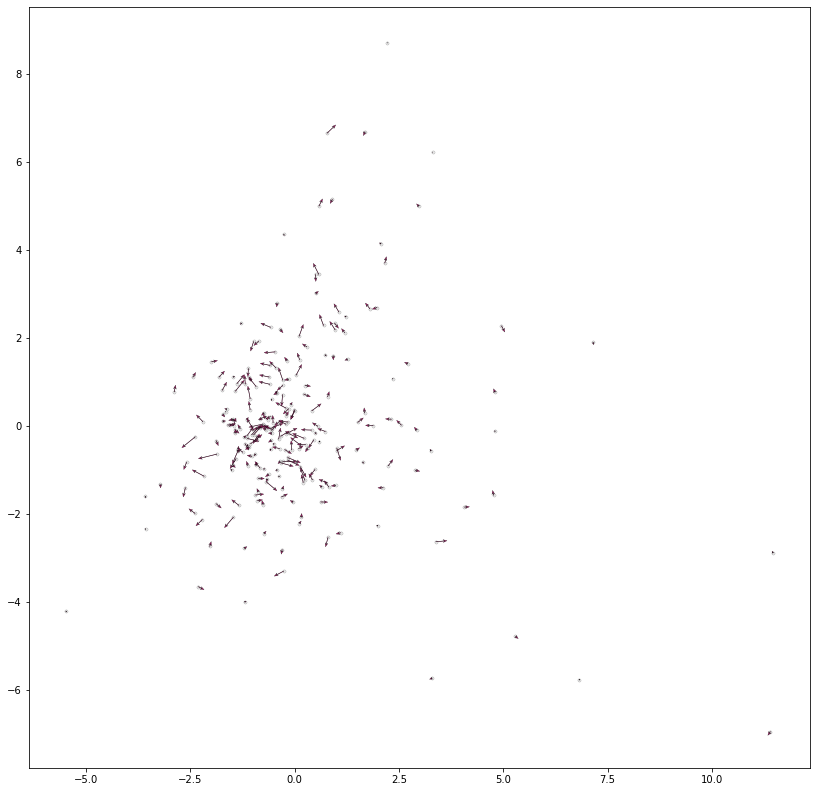

In [331]:
plt.figure(None,(14,14))
quiver_scale = 60

plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

# plt.axis("off")
plt.savefig("full_arrows.pdf")

2020-01-14 14:23:33,642 - WARNING - The arrow scale was set to be 'absolute' make sure you know how to properly interpret the plots
2020-01-14 14:23:33,668 - DEBUG - Assigning font /b'F1' = '/opt/miniconda3/envs/ARMOR/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2020-01-14 14:23:33,675 - DEBUG - Embedding font /opt/miniconda3/envs/ARMOR/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2020-01-14 14:23:33,676 - DEBUG - Writing TrueType font.


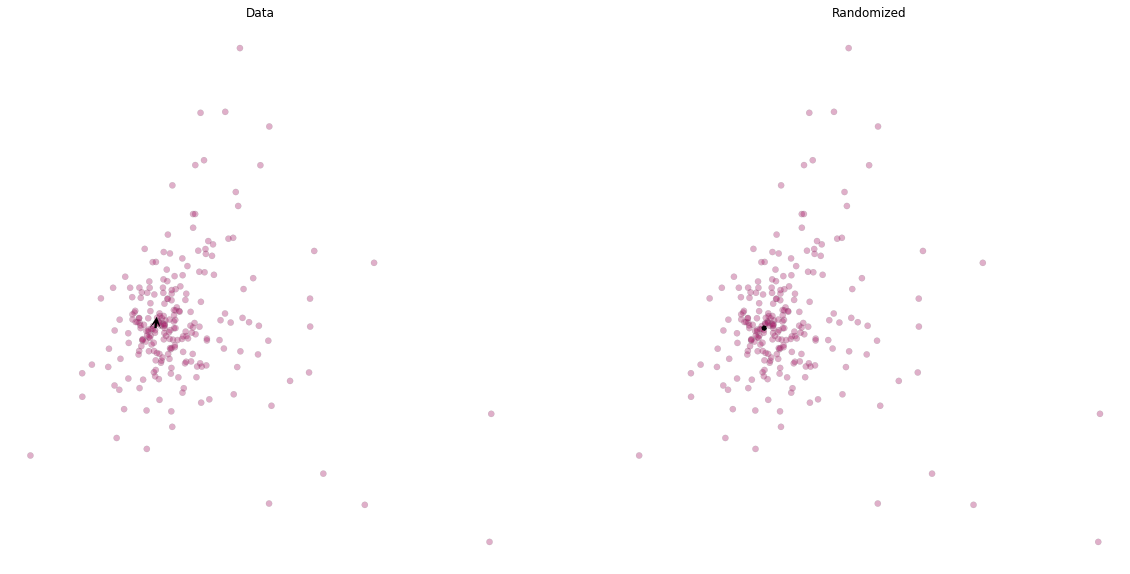

In [330]:
# initial divide by mean
plt.figure(None,(20,10))
vlm.plot_grid_arrows(quiver_scale=0.48,
                     scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=24, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, minlength=1.5,
                     plot_random=True, scale_type="absolute")
plt.savefig("vectorfield.pdf")